In [25]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**GAN for MNIST Dataset to Generate Digits**

In this work, I download and create popular hand writing digits dataset MNIST. Using this dataset, I built a custom generative adversarial network, to generate non-existing images of hand writing digits.

Main difficulty was preventing mode-collapse risk, which is generator generates same class data to trick discriminator.

Another difficulty was that discriminator or generator always overpowered against another, which prevents architecture to convergence.

**Helper Functions for Visualization**

In [26]:
import torch, torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

#Helpers for visualization

def torch_imshow(img):
    img = img[0]
    plt.imshow(img.cpu().numpy())
    plt.show()
    

class GANVisualizer:
    '''
    This class is a utility for visualizing
    generator samples using fixed latent vector to
    track the training of a GAN.
    '''
    def __init__(self):
        self.z = torch.randn(16, 100).cuda()
    
    def visualize(self, generator):
        with torch.no_grad():
            imgs = generator(self.z)
            fig, axes = plt.subplots(4, 4, figsize=(15, 15))
            for n in range(16):
                axis_row = n // 4
                axis_col = n % 4
                
                subplot = axes[axis_row, axis_col] 
                subplot.axis('off')
                img = subplot.imshow(imgs[n].cpu().reshape(28, 28))
                img.set_cmap('gray')
        plt.show()

visualizer = GANVisualizer() 

In [27]:
#Create dataset and dataloader
BATCH_SIZE = 16

mnist = torchvision.datasets.MNIST('./', train=True, download=True, transform=torchvision.transforms.ToTensor())
train_dataloader = DataLoader(dataset=mnist, batch_size=BATCH_SIZE, shuffle=True)

Using downloaded and verified file: ./MNIST/raw/train-images-idx3-ubyte.gz
Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


0it [00:00, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


0it [00:00, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


0it [00:00, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729047590/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


**Generator and Discriminator Networks**

In [28]:
class FCNet(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.layers =  torch.nn.Sequential(
            torch.nn.Linear(input_dim,hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim,output_dim),
            torch.nn.Sigmoid()
            
        )
    def forward(self, x):
        x = self.layers(x)
        return x
        
        
generator     = FCNet(100, 256, 784)
discriminator = FCNet(784, 256, 1)


print('--Generator--')
dummy_input_g = torch.randn(16, 100)
dummy_output_g = generator(dummy_input_g)
print(generator)
print(f'Dummy input shape: {dummy_input_g.shape}')
print(f'Dummy output shape: {dummy_output_g.shape}')


print('--Discriminator--')
print(discriminator)
dummy_input_d = torch.randn(16, 784)
dummy_output_d = discriminator(dummy_input_d)
print(f'Dummy input shape: {dummy_input_d.shape}')
print(f'Dummy output shape: {dummy_output_d.shape}')



--Generator--
FCNet(
  (layers): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=784, bias=True)
    (3): Sigmoid()
  )
)
Dummy input shape: torch.Size([16, 100])
Dummy output shape: torch.Size([16, 784])
--Discriminator--
FCNet(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
Dummy input shape: torch.Size([16, 784])
Dummy output shape: torch.Size([16, 1])


**Optimizers and Loss Function**

In [29]:
# Define an optimizer for both generator and discriminator

lr = 0.001

######################1
g_optimizer = torch.optim.Adam(generator.parameters(), lr)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr)

loss_fn = torch.nn.MSELoss()
#####################2

**Training and Results**

Epoch: 1


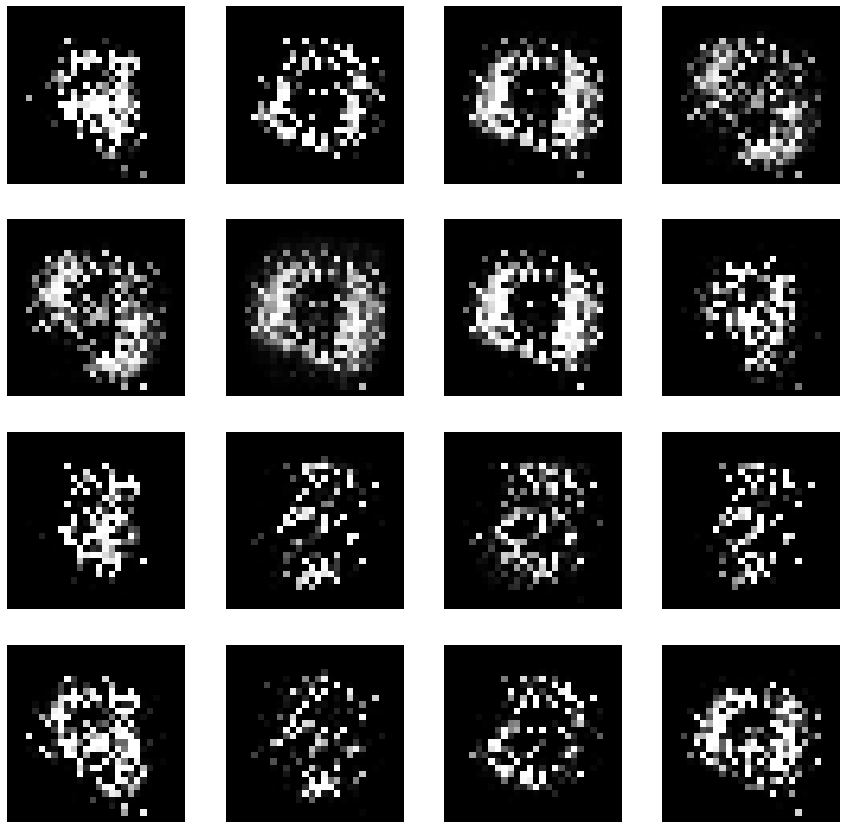

tensor(0.0015, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9541, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch: 2


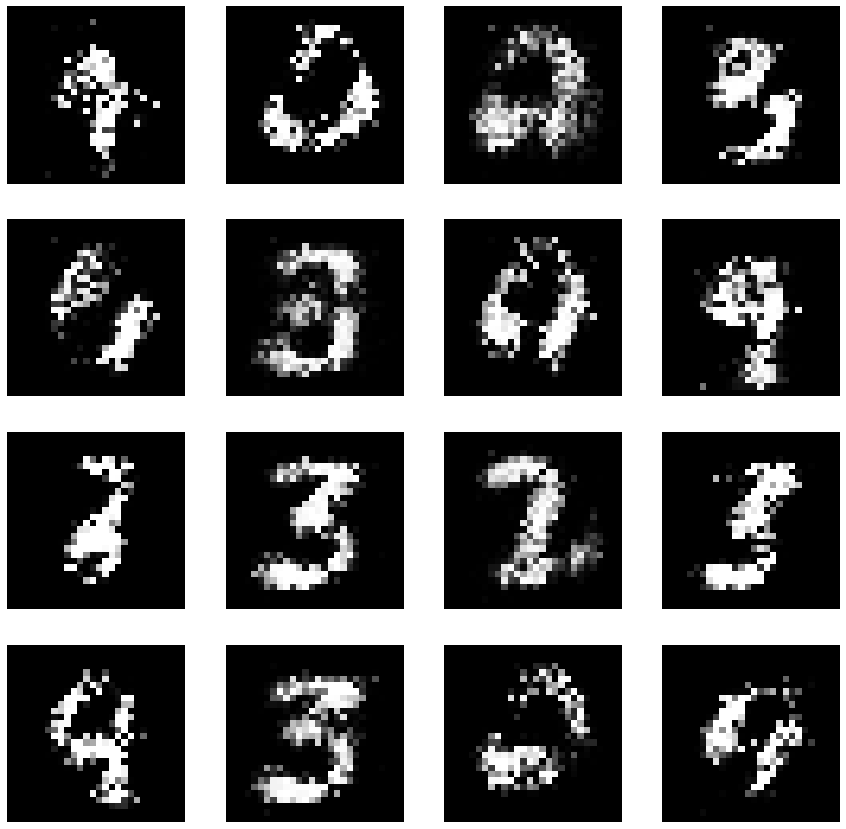

tensor(0.0787, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7814, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch: 3


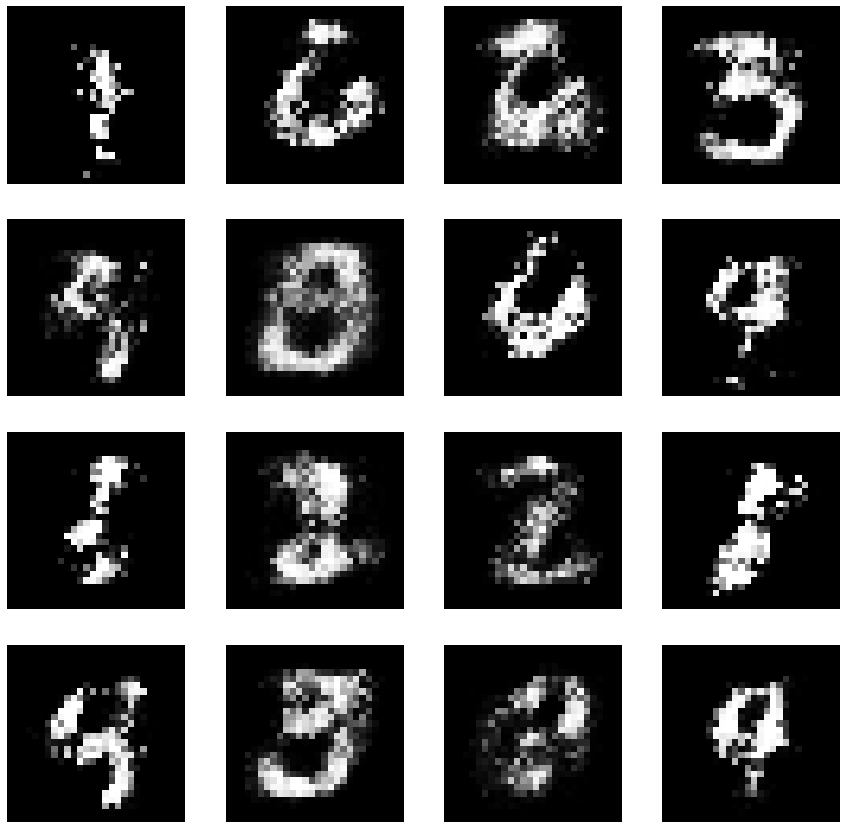

tensor(0.0769, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7110, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch: 4


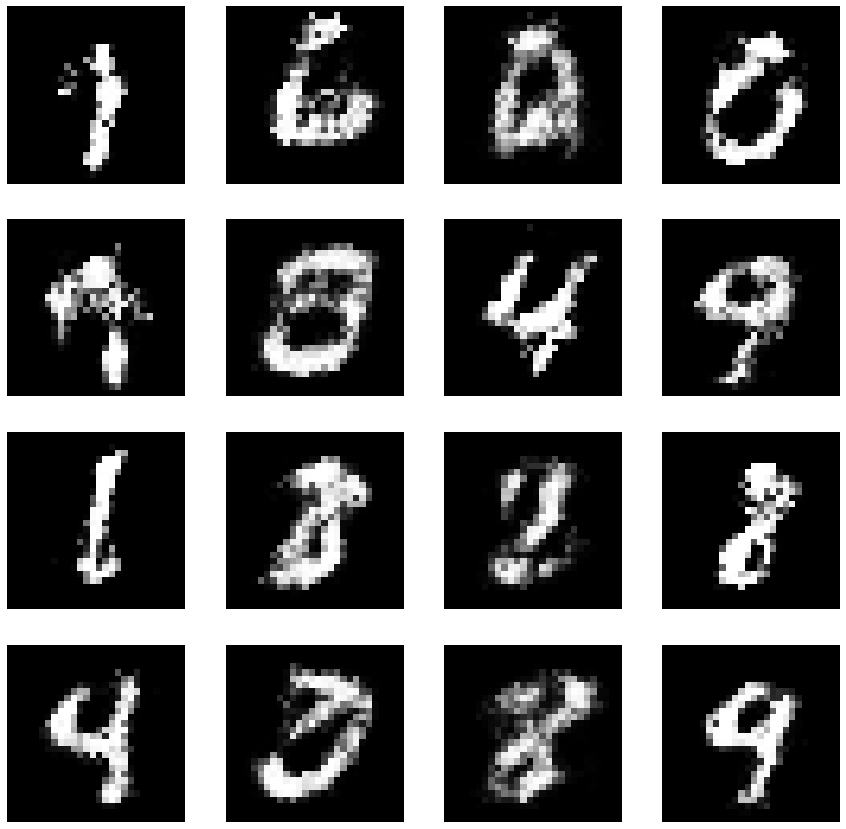

tensor(0.1448, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6615, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch: 5


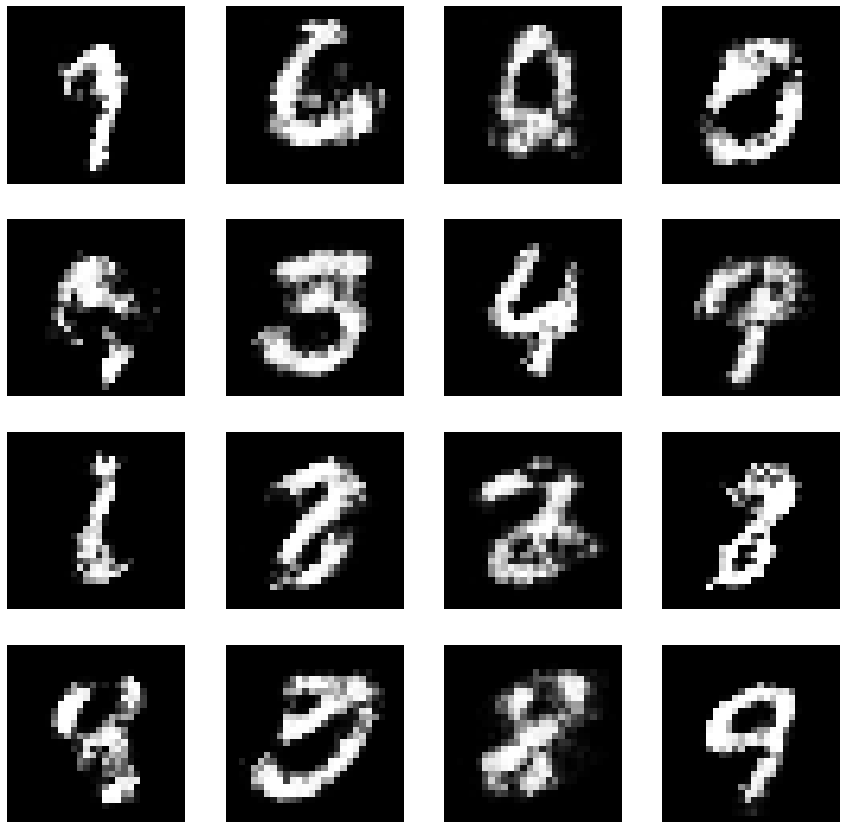

tensor(0.2162, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6180, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch: 6


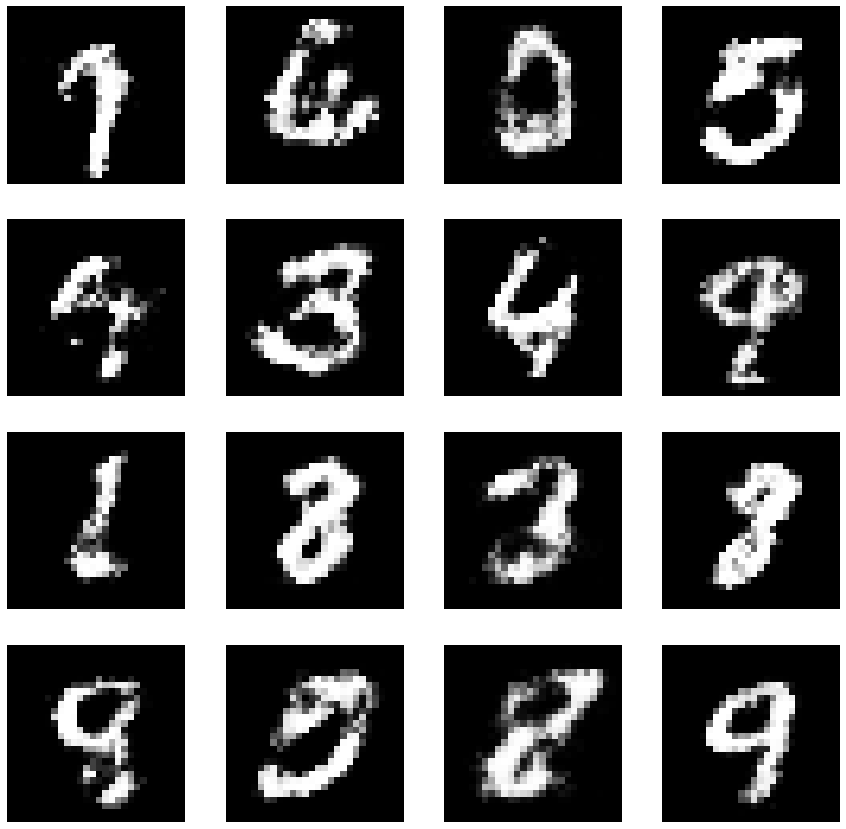

tensor(0.2942, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5763, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch: 7


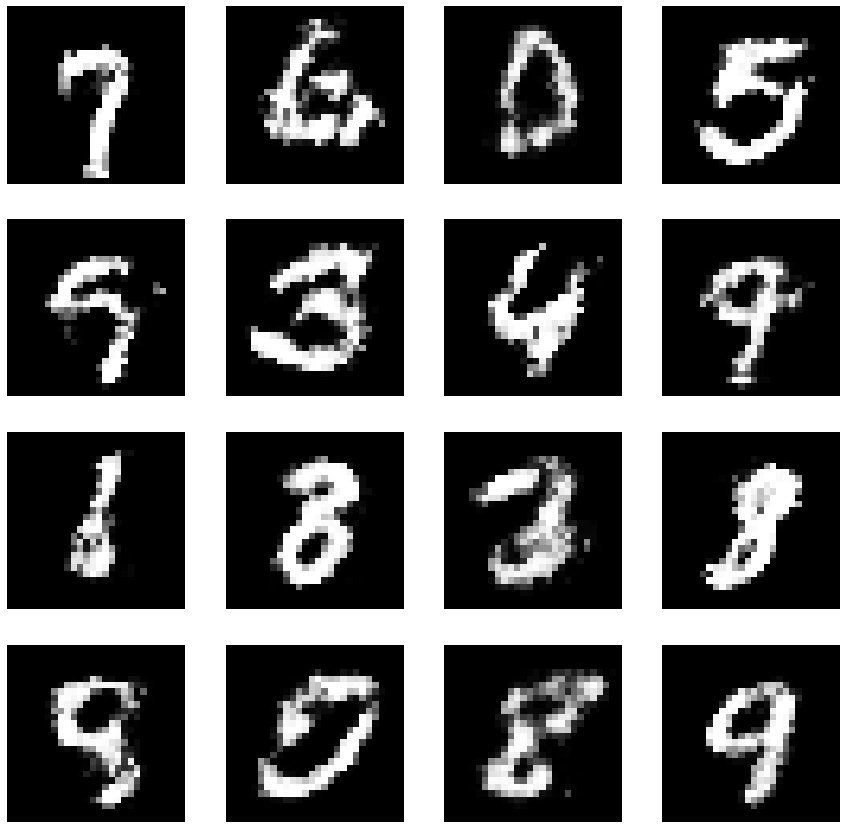

tensor(0.2788, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5418, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch: 8


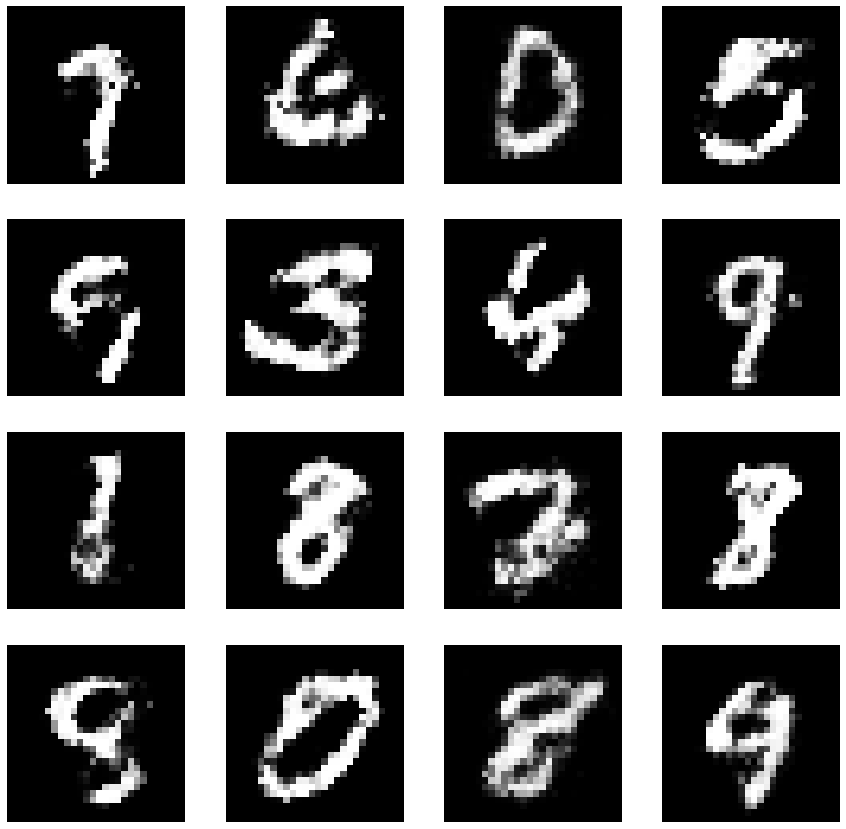

tensor(0.2519, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6609, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch: 9


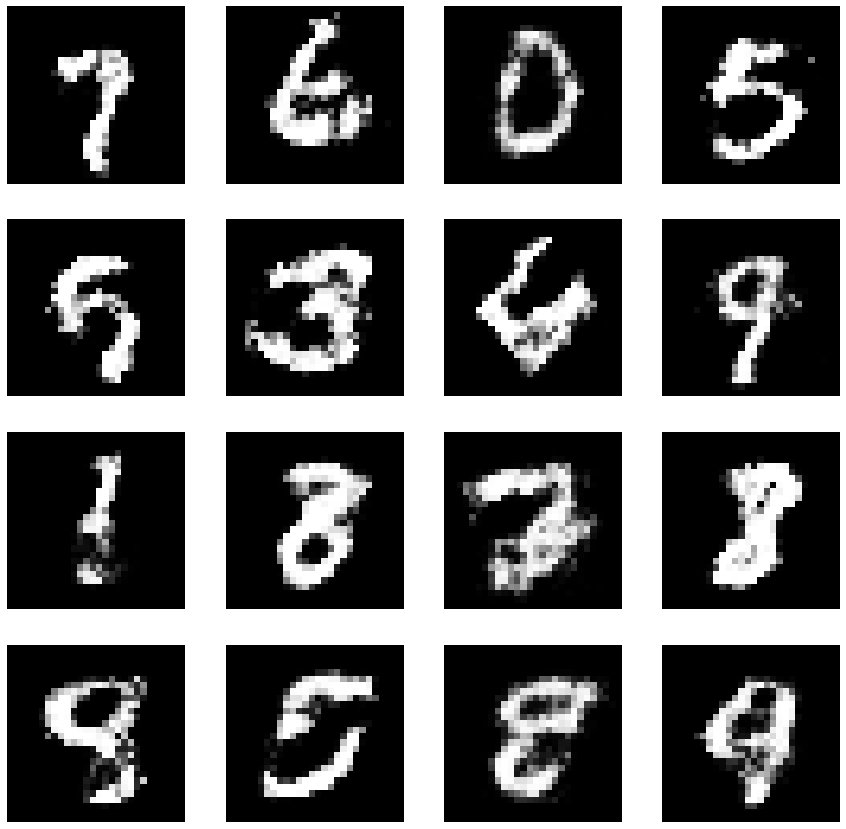

tensor(0.3288, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6533, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch: 10


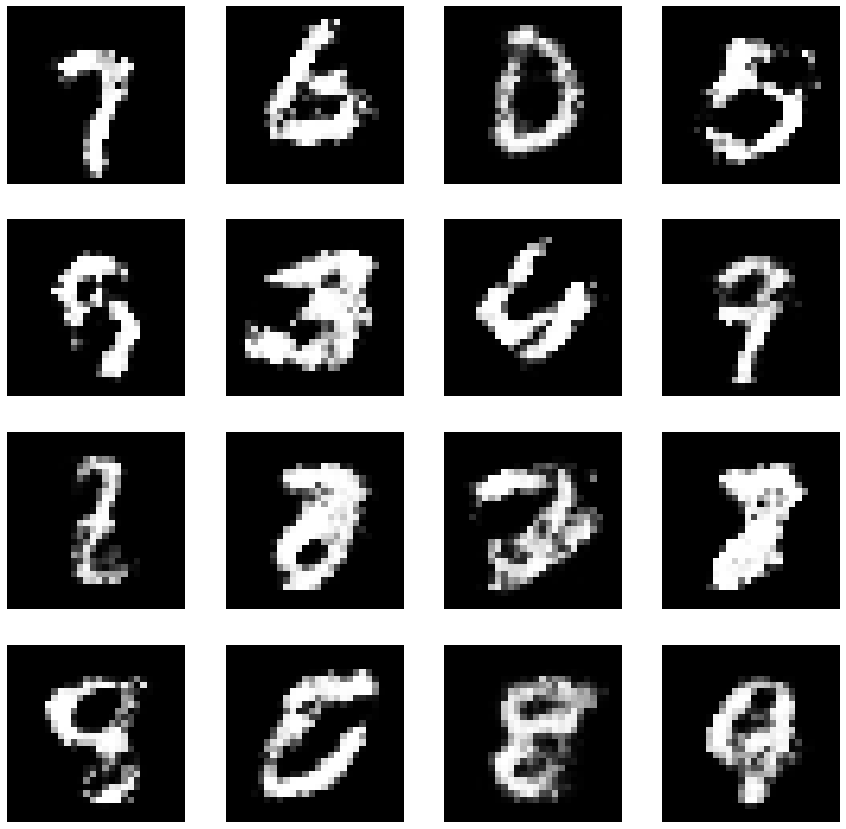

tensor(0.1663, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6781, device='cuda:0', grad_fn=<MseLossBackward>)


In [30]:
generator = generator.to("cuda")
discriminator = discriminator.to("cuda")

for epoch in range(10): 
    print(f'Epoch: {epoch + 1}')
    
    for iteration, (real_imgs, labels) in enumerate(train_dataloader):
        real_imgs = real_imgs.reshape(-1, 784).cuda()
        z = torch.randn(BATCH_SIZE, 100).cuda()
        
        ones = torch.ones(BATCH_SIZE,1).cuda()
        zeros = torch.zeros(BATCH_SIZE,1).cuda()

        ## train generator 1 step       

        generator.zero_grad()

        generator_output = generator(z) #output of generator

        discriminator_output = discriminator(generator_output)

        g_loss = loss_fn(discriminator_output, ones)
        
        g_loss.backward()

        g_optimizer.step()
  

        #train discriminator 1 step
        
        discriminator.zero_grad()

        # train on real images (loss(real,ones))
        
        x_real = real_imgs

        d_out_real = discriminator(x_real).cuda()
        
        d_real_loss = loss_fn(d_out_real, ones)

        # train on fake images (loss(fake,zeros)) 
        z = torch.randn(BATCH_SIZE, 100).cuda() 

        x_fake = generator(z)

        D_output_fake = discriminator(x_fake)

        d_fake_loss = loss_fn(D_output_fake, zeros)

        # sum real+fake losses 

        d_loss = d_real_loss + d_fake_loss

        d_loss.backward()

        d_optimizer.step()
    
    # Visualize generator samples after the epoch
    visualizer.visualize(generator)

    print(d_loss, g_loss)


When we look at the results, it can be seen that both generator and discriminator converged very well.  Both of networks losses are low, around 0.2 and 0.5. 

Additionally, after 4th epoch, we can see that network produces realistic images.

However, we still see mode-collapse error because even for the last epoch, usually 9, 8, 1 and 3 are generated.